#Installazione pacchetti necessari

In [0]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations==0.3.0 --user 
!pip install -U --pre segmentation-models --user
#!pip install git+https://github.com/qubvel/segmentation_models --user

     |████████████████████████████████| 81kB 4.1MB/s 
     |████████████████████████████████| 21.6MB 1.4MB/s 
     |████████████████████████████████| 634kB 50.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.3.0-cp36-none-any.whl size=46998 sha256=8c6302ba79c70f33826b816938b54a9b5b07c5a7fb51833d78f384dfa94a43ce
  Stored in directory: /root/.cache/pip/wheels/f0/20/08/c30ec4f36c3abe52bfb5a980434d4017776f17266071425c9b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=ec8ad518eb41a7434e8e144612b673fc6a18ce5eb5402183c3036d50eb8b4d6d
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug


# Connessione a directory Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading Dataset pre processing compresso

In [0]:
import numpy as np
PATH_BASE = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/npy_files/'

In [0]:
dataset_pre_processing_nneigh_pad = np.load(PATH_BASE + "dataset_pre_processing_nneigh_pad.npz")

## Zero padding per estensione superficie immagini

In [4]:
immagini_db_nneigh_pad = dataset_pre_processing_nneigh_pad["immagini_db_nneigh_zeropadding"]
immagini_db_nneigh_pad.shape

(1446, 320, 320, 3)

## Zero padding anche sulle label

In [5]:
reshaped_labels_nneigh_pad = dataset_pre_processing_nneigh_pad["reshaped_labels_zeropadding"]
reshaped_labels_nneigh_pad.shape

(1446, 320, 320)

## Passaggio a 41 channel

Si passa da WxH a WxHxC dove C rappresenta i singoli cluster

In [0]:
def process_channels(reshaped_labels, n_labels):
  reshaped_labels_processed = np.zeros((reshaped_labels.shape[0], reshaped_labels.shape[1], reshaped_labels.shape[2], n_labels), dtype="uint8")
  for n in range(0, reshaped_labels_processed.shape[0]):
    for i in range(0, reshaped_labels_processed.shape[1]):
      for j in range(0, reshaped_labels_processed.shape[2]):
        reshaped_labels_processed[n][i][j][reshaped_labels[n][i][j]] = 1
  return reshaped_labels_processed

In [0]:
reshaped_labels_processed_nneigh_pad = process_channels(reshaped_labels_nneigh_pad, 41)

In [0]:
np.savez_compressed(PATH_BASE + "normals_centroid_labels_pad_41channels.npz", reshaped_labels_processed_nneigh_pad = reshaped_labels_processed_nneigh_pad)

In [0]:
reshaped_labels_processed_nneigh_pad_load = np.load(PATH_BASE + "normals_centroid_labels_pad_41channels.npz")
reshaped_labels_processed_nneigh_pad = reshaped_labels_processed_nneigh_pad_load["reshaped_labels_processed_nneigh_pad"]

In [7]:
reshaped_labels_processed_nneigh_pad.shape

(1446, 320, 320, 41)

# Modellizzazione

## Costruzione splitting

In [6]:
normali_nneigh = dataset_pre_processing_nneigh_pad["normali_nneigh"]
normali_nneigh.shape

(1446, 240, 320, 3)

In [0]:
np.random.seed(1221)
indexes = range(0,reshaped_labels_processed_nneigh_pad.shape[0])
permutated_indexes = np.random.permutation(indexes)
reshaped_labels_processed_nneigh_pad = reshaped_labels_processed_nneigh_pad[permutated_indexes, ...]
immagini_db_nneigh_pad = immagini_db_nneigh_pad[permutated_indexes, ...]

In [0]:
index_trainval = round(immagini_db_nneigh_pad.shape[0]*0.7)
x_trainval, y_trainval = immagini_db_nneigh_pad[:index_trainval, ...], reshaped_labels_processed_nneigh_pad[:index_trainval, ...]
x_test, y_test = immagini_db_nneigh_pad[index_trainval:, ...], reshaped_labels_processed_nneigh_pad[index_trainval:, ...]
normali_nneigh_test = normali_nneigh[index_trainval:, ]

In [0]:
index_train = round(x_trainval.shape[0]*0.8)
x_train, y_train = immagini_db_nneigh_pad[:index_train, ...], reshaped_labels_processed_nneigh_pad[:index_train, ...]
x_val, y_val = immagini_db_nneigh_pad[index_train:, ...], reshaped_labels_processed_nneigh_pad[index_train:, ...]

In [0]:
np.save(PATH_BASE + "x_nneigh_pad_test.npy", x_test)
np.save(PATH_BASE + "y_nneigh_pad_test.npy", y_test)
np.save(PATH_BASE + "normali_nneigh_test.npy", normali_nneigh_test)

## Costruzione modello

In [0]:
import cv2
import tensorflow as tf
import keras
#import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """Normal surface dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        x (nparray): images
        y (nparray): label
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            x, 
            y, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.x = x
        self.y = y
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        if not isinstance(i, tuple):
          image = self.x[i]
          label = self.y[i]
        else:
          start, stop = i 
          image = self.x[start:stop,]
          label = self.y[start:stop,]
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, label=label)
            image, mask = sample['image'], sample['label']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, label=label)
            image, mask = sample['image'], sample['label']
            
        return image, label
        
    def __len__(self):
        return self.x.shape[0]
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()
# Rivedere senza fare copia degli oggetti
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        #batch = [np.stack(samples, axis=0) for samples in zip(self.dataset[(start, stop)])]
        #batch = self.dataset[(start,stop)]
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

Costruzione modello

In [0]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'efficientnetb3'
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [0]:
# define network parameters
n_classes = 41
activation = 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44113920/44107200 [==============================] - 1s 0us/step


Calcolo dei pesi

In [0]:
class_weights = np.load(PATH_BASE + "label_weights_nneigh_pad.npy")

In [0]:
class_weights_fixed = np.zeros(41)

In [0]:
# TODO ATTENZIONE CLUSTER VUOTI EMBEDDATI
j = 0
for i in np.unique(reshaped_labels_nneigh_pad):
  class_weights_fixed[i] = class_weights[j]
  j+=1
print(class_weights_fixed)

[ 2.77176033  0.77836628  1.40650118  3.47250472  1.70909468  9.18467169
  0.96732816  2.83436474  3.65351749  1.58229353  7.10121149  0.
  1.01426528  0.79931976  0.          0.74095713  0.35586178  4.46051273
  6.96001988  3.37918533  3.56589907  0.71095304  6.13601376  1.01339842
  6.99552986  0.83308215  3.88495077  1.87622434  1.29410874  3.98119746
  0.71376734  0.63885554  0.84777493  1.03069152 18.0852701   1.16008519
  2.58354321  7.89617204  2.37959337  0.28933215  0.1025641 ]


In [0]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights_fixed)
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [0]:
# Dataset for train images
train_dataset = Dataset(
    x_train, 
    y_train
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_val, 
    y_val
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, TRAIN_BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, VAL_BATCH_SIZE, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (TRAIN_BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (TRAIN_BATCH_SIZE, 320, 320, 41)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model_nneigh.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [0]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/40
101/101 [==============================] - 80s 789ms/step - loss: 0.9786 - iou_score: 0.0505 - f1-score: 0.0521 - val_loss: 0.9783 - val_iou_score: 0.0521 - val_f1-score: 0.0551
Epoch 2/40
101/101 [==============================] - 76s 749ms/step - loss: 0.9484 - iou_score: 0.0546 - f1-score: 0.0594 - val_loss: 0.9460 - val_iou_score: 0.0537 - val_f1-score: 0.0579
Epoch 3/40
101/101 [==============================] - 76s 749ms/step - loss: 0.9116 - iou_score: 0.0572 - f1-score: 0.0637 - val_loss: 0.9201 - val_iou_score: 0.0538 - val_f1-score: 0.0580
Epoch 4/40
101/101 [==============================] - 76s 748ms/step - loss: 0.8724 - iou_score: 0.0593 - f1-score: 0.0674 - val_loss: 0.9161 - val_iou_score: 0.0539 - val_f1-score: 0.0582
Epoch 5/40
101/101 [==============================] - 75s 747ms/step - loss: 0.8215 - iou_score: 0.0661 - f1-score: 0.0786 - val_loss: 0.8813 - val_iou_score: 0.0587 - val_f1-score: 0.0659
Epoch 6/40
101/101 [==============================] - 7

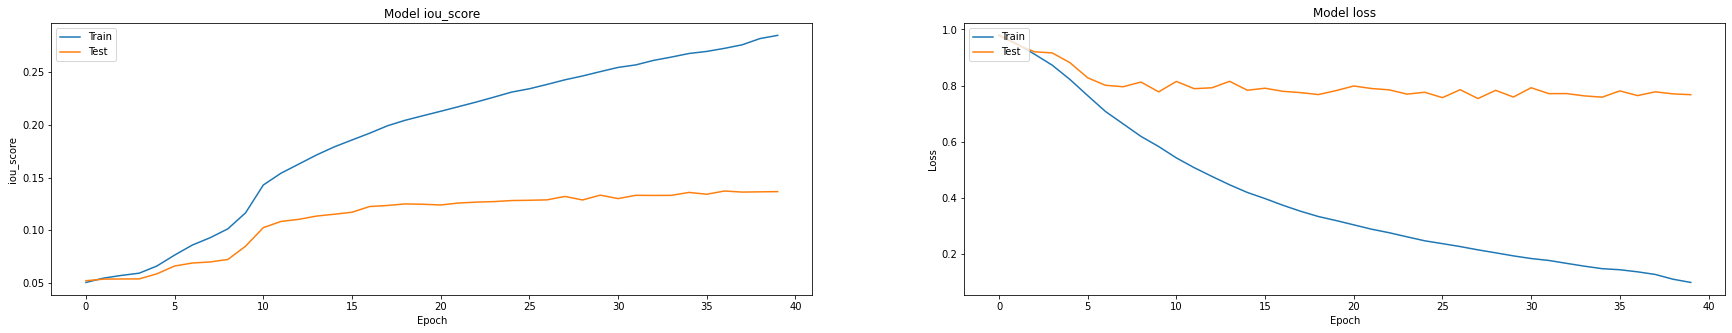

In [0]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calcolo output predizionale della rete

In [0]:
from keras.models import load_model
model.load_weights("best_model.h5")

In [0]:
y_test_p = model.predict(x_test, batch_size=1)

In [0]:
np.save(PATH_BASE + "prediction_test_padded.npy", y_test_p)